In [ ]:
'''
№0. Строку в которой записано своё ФИО подать на вход в хеш-функцию ГОСТ Р 34.11-2012 (Стрибог). Младшие 4 бита выхода интерпретировать как число, которое в дальнейшем будет номером варианта. Процесс выбора варианта требуется отразить в отчёте.
№1. Программно реализовать один из алгоритмов функции хеширования в соответствии с номером варианта. Алгоритм содержит в себе несколько раундов.
№2. Модифицировать оригинальный алгоритм таким образом, чтобы количество раундов было настраиваемым параметром программы. в этом случае новый алгоритм не будет являться стандартом, но будет интересен для исследования.
№3. Применить подходы дифференциального криптоанализа к полученным алгоритмам с разным числом раундов.
№4. Построить график зависимости количества раундов и возможности различения отдельных бит при количестве раундов 1,2,3,4,5,... .
№5. Сделать выводы.

Примечание №1. Допустимо использовать сторонние реализации для пункта 1, при условии, что они проходят тесты из стандарта и пригодны для дальнейшей модификации.

Примечание №2. Если в алгоритме описывается семейство с разными размерами блоков, то можно выбрать любой из них.
'''

In [34]:
import math
import random
import hashlib
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def md5_built_in(s):
    return hashlib.md5(s).hexdigest()

rotate_amounts = [7, 12, 17, 22, 7, 12, 17, 22, 7, 12, 17, 22, 7, 12, 17, 22,
                  5, 9, 14, 20, 5, 9, 14, 20, 5, 9, 14, 20, 5, 9, 14, 20,
                  4, 11, 16, 23, 4, 11, 16, 23, 4, 11, 16, 23, 4, 11, 16, 23,
                  6, 10, 15, 21, 6, 10, 15, 21, 6, 10, 15, 21, 6, 10, 15, 21]

tsin = [int(abs(math.sin(i + 1)) * 2 ** 32) & 0xFFFFFFFF for i in range(64)]

init_values = [0x67452301, 0xefcdab89, 0x98badcfe, 0x10325476]

functions = [lambda b, c, d: (b & c) | (~b & d), 
             lambda b, c, d: (d & b) | (~d & c),
             lambda b, c, d: b ^ c ^ d ,
             lambda b, c, d: c ^ (b | ~d)]

index_functions = [lambda i: i,
                   lambda i: (5 * i + 1) % 16,
                   lambda i: (3 * i + 5) % 16,
                   lambda i: (7 * i) % 16]


def left_rotate(x, amount):
    x &= 0xFFFFFFFF
    return ((x << amount) | (x >> (32 - amount))) & 0xFFFFFFFF



def md5(message_, rounds=4):
    message = bytearray(message_)  # copy our input into a mutable buffer
    orig_len_in_bits = (8 * len(message)) & 0xffffffffffffffff
    message.append(0x80)
    while len(message) % 64 != 56:
        message.append(0)
    message += orig_len_in_bits.to_bytes(8, byteorder='little')

    hash_pieces = init_values[:]

    for chunk_ofst in range(0, len(message), 64):   # блоки по 64 байта (512 бит)
        a, b, c, d = hash_pieces
        chunk = message[chunk_ofst:chunk_ofst + 64]  # берем очередной блок
        for rr in range(rounds):
            r = rr % 4
            for kk in range(16):
                i = r*16 + kk
                k = index_functions[r](i)   # вычисляем номер под-блока данных (0...15)
                x_k = int.from_bytes(chunk[4*k : 4*k+4], byteorder='little')
                f = functions[r](b, c, d)
                to_rotate = a + f + tsin[i] + x_k
                new_b = (b + left_rotate(to_rotate, rotate_amounts[i])) & 0xFFFFFFFF
                a, b, c, d = d, new_b, b, c
        for i, val in enumerate([a, b, c, d]):
            hash_pieces[i] += val
            hash_pieces[i] &= 0xFFFFFFFF

    return sum(x << (32 * i) for i, x in enumerate(hash_pieces))


def md5_to_hex(digest):
    raw = digest.to_bytes(16, byteorder='little')
    return '{:032x}'.format(int.from_bytes(raw, byteorder='big'))


In [16]:
def count_diff_bits(hash_hexstr1, hash_hexstr2):
    return bin(int(hash_hexstr1, 16) ^ int(hash_hexstr2, 16)).count('1')

In [17]:
def get_random_string(N=50):
    return ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(N))

In [19]:
for i in range(1000):
    message = get_random_string(random.randint(100, 2000))
    message_bytes = message.encode('utf-8')
    equal = (md5_to_hex(md5(message_bytes) == md5_built_in(message_bytes)))
    if not equal:
        print('aaa')
print('ok, all results of 4 rounds md5 equal to built-in implementation.')

ok, all results of 4 rounds md5 equal to built-in implementation.


In [21]:
import pandas as pd

In [40]:
res = pd.DataFrame(columns='id rounds diffbits len'.split())
for m in range(10):
    message = get_random_string(random.randint(100, 2000))
    print(len(message))
    orig_msg_bytes = message.encode('utf-8')
    orig_hash = md5_to_hex(md5(message_bytes))
    for i in range(10):
        changed_msg_bytes = change_random_bit(orig_msg_bytes)
        for r in range(1, 50):
            changed_hash = md5_to_hex(md5(changed_msg_bytes, rounds=r))
            diff = count_diff_bits(orig_hash, changed_hash)
            res = res.append({'id': m, 'rounds': r, 'diffbits': diff, 'len': len(message)}, ignore_index=True)
# message_bytes[-1] ^= 1                       # ((m >> 1) << 1) | ~(m & 1)
# equal = ( == md5_built_in(message_bytes)))

500
1423
688
867
1468
1235
861
1770
1290
1422


In [58]:
res['id2'] = res['id'].astype('str')

In [59]:
res

,id,rounds,diffbits,len,id2
0,0,1,57,500,0
1,0,2,54,500,0
2,0,3,78,500,0
3,0,4,62,500,0
4,0,5,60,500,0
5,0,6,65,500,0
6,0,7,60,500,0
7,0,8,53,500,0
8,0,9,58,500,0
9,0,10,55,500,0


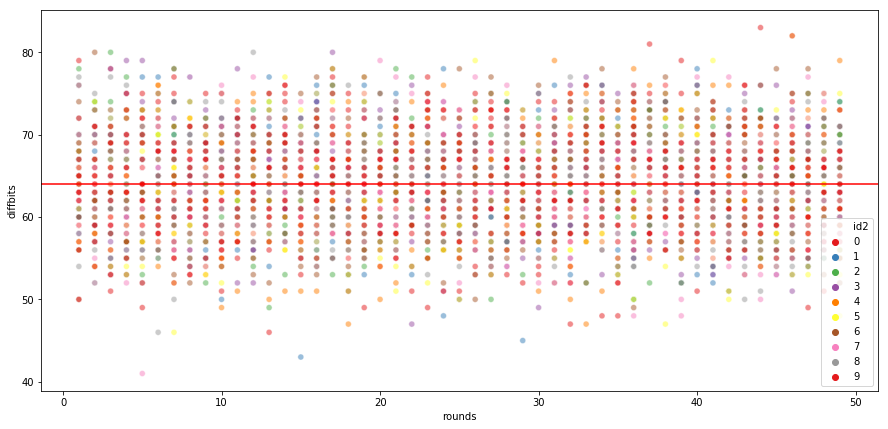

In [64]:
fig = plt.figure(figsize=(15, 7))
sns.scatterplot(data=res, x='rounds', y='diffbits', hue='id2', 
                palette=sns.color_palette("Set1", res['id'].nunique()), alpha=0.5)
plt.axhline(y=64, color='red')

In [66]:
80/128

0.625

In [65]:
50/128

0.390625

In [30]:
def change_random_bit(bytes_in):
    i = random.randint(0, len(bytes_in)-1)
    j = random.randint(0, 7)
    b = bytearray(bytes_in)
    b[i] ^= (1 << j)
    return bytes(b)